### Plotting of general 2D fileds from ZM KE 2d simulations

In [1]:
import xarray as xr
import numpy as np
import geocat.comp as gc

import cartopy.crs as ccrs
import matplotlib.pyplot as mp
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.util as caru

Q
* Sim =  f.e21.F2000climo.f19_f19.cesm2_1.zmke.000
0
* Sim =  f.e21.F2000climo.f19_f19.cesm2_1.zmke.003


/glade/work/rneale/python/miniconda3/envs/neale_vproc/lib/python3.10/site-packages/metpy/interpolate/one_dimension.py:142: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/glade/work/rneale/python/miniconda3/envs/neale_vproc/lib/python3.10/site-packages/metpy/interpolate/one_dimension.py:152: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/glade/work/rneale/python/miniconda3/envs/neale_vproc/lib/python3.10/site-packages/metpy/interpolate/one_dimension.py:142: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/glade/work/rneale/python/miniconda3/envs/neale_vproc/lib/python3.10/site-packages/metpy/interpolate/one_dimension.py:152: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out o

1
* Sim =  f.e21.F2000climo.f19_f19.cesm2_1.zmke.004
2


/glade/work/rneale/python/miniconda3/envs/neale_vproc/lib/python3.10/site-packages/metpy/interpolate/one_dimension.py:142: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/glade/work/rneale/python/miniconda3/envs/neale_vproc/lib/python3.10/site-packages/metpy/interpolate/one_dimension.py:152: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')


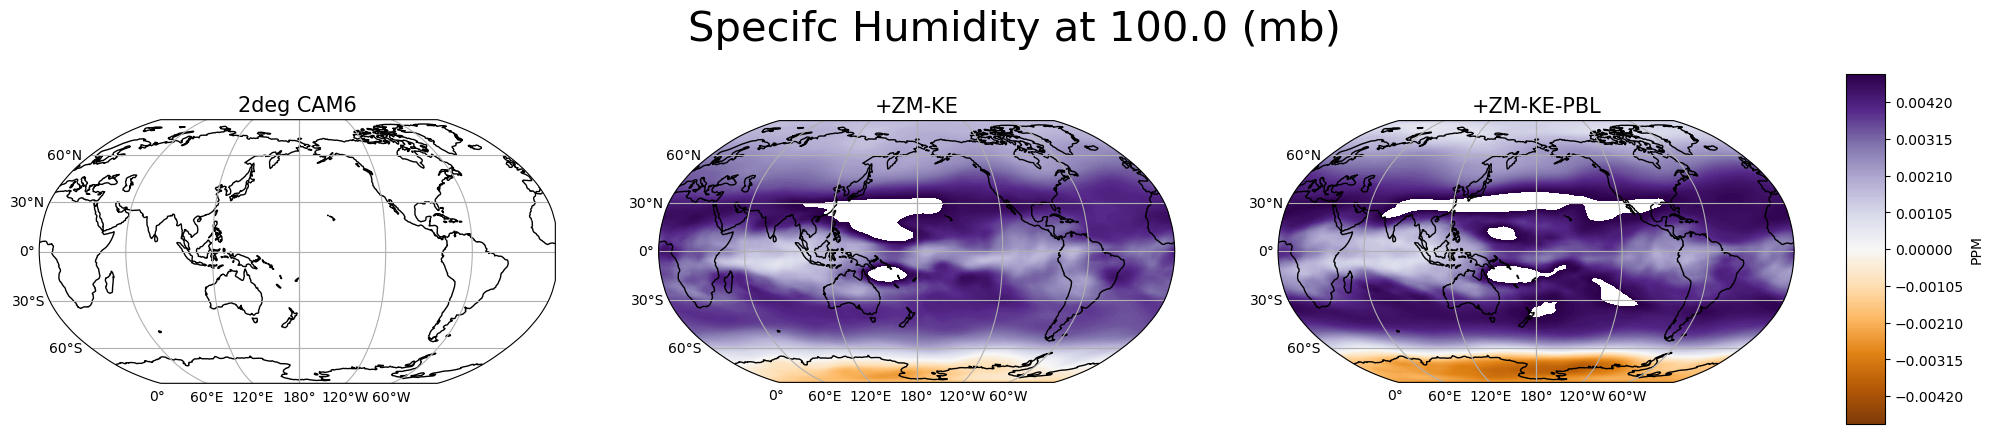

In [5]:
pproj = ccrs.Robinson(central_longitude = 180.)
ptrans=ccrs.PlateCarree()





dir_climo = '/glade/scratch/rneale/archive/'
cam_runs = ['f.e21.F2000climo.f19_f19.cesm2_1.zmke.000','f.e21.F2000climo.f19_f19.cesm2_1.zmke.003','f.e21.F2000climo.f19_f19.cesm2_1.zmke.004']
cam_names = ['2deg CAM6','+ZM-KE','+ZM-KE-PBL']
season = 'DJF'
ldiff = True


#mvars = ['PRECC','PRECL','LEL','LCL']
mvars = ['Q']
mvscale = [86400.*1000,86400.*1000,1,1]


#####
dir_fig = '/glade/u/home/rneale/python/python-figs/zm_dev/'
ds_run = []

for isim,crun in enumerate(cam_runs):
    file_in = dir_climo+cam_runs[isim]+'/climo/'+cam_runs[isim]+'_'+season+'_climo.nc'

    ds_run_ip = xr.open_dataset(file_in,engine='netcdf4')    
    ds_run.append(ds_run_ip)
   
    ds = xr.concat(ds_run,dim='simulation')
    
    nlons = len(ds['lon'])
    nlats = len(ds['lat'])

ds = ds.isel(time=0) # This simulation.
    
for ip,vname in enumerate(mvars):
    
    fig, ax = mp.subplots(nrows=1,ncols=3,
                        subplot_kw={'projection': pproj},
                        figsize=(26,5))
    
    print(vname)
    for isim,crun in enumerate(cam_runs):
        
        print('* Sim = ',crun)
        
        ds_i = ds.isel(simulation=isim) # This simulation.
        da = ds_i[vname] # This simulation.
        long_name = da.attrs["long_name"]
        
        da_ps = ds_i['PS']
        hyam = ds_i['hyam'] ; hybm = ds_i['hybm']
        plevs = hyam*100000+da_ps*hybm
        
        cmap = 'terrain'
        
        
        if (vname == 'LEL'):
            da_int = da.astype(int)-1
            
            long_name = 'Pressure of Mean Convective Cloud Top (mb)'
            
            da=plevs[da_int,:,:]           
            da = da*0.01 # in mb

        if (vname in ['Q','ZMDT','ZMDQ']):
           
            plev_plot =100.
            
            da = gc.interpolation.interp_hybrid_to_pressure(da, da_ps, hyam, hybm, p0=100000.0,
                    lev_dim=None, method='linear', extrapolate=False, variable=None, t_bot=None, phi_sfc=None)
            
            if vname == 'Q':
                long_name = 'Specifc Humidity at '+str(plev_plot)+' (mb)'
                vunits = 'PPM'
                vscale = 1000*1000.   # in ppm?
                cmap = 'PuOr'
                max_level = 0.000005 *1000.
                min_level = -0.000005 *1000.
                step_level = 0.00000005*1000.
            
            
            if vname == 'ZMDT':
                long_name = 'Deep convective heating at '+str(plev_plot)+' (mb)'
                vunits = 'K/day'
                vscale = 86400
                cmap = 'bwr'
                
                max_level = 0.012
                min_level = -0.012
                step_level = 0.00012
                
            if vname == 'ZMDQ':
                long_name = 'Deep convective moistening at '+str(plev_plot)+' (mb)'
                vunits = 'PPM/day'
                vscale = 86400*1000.*1000.   # in ppm?
                cmap = 'PuOr'
                max_level = 0.001 *1000.
                min_level = -0.001 *1000.
                step_level = 0.00001* 1000.
            
            da = vscale*da.sel(plev=plev_plot*100.)*0.01 # in mb
            
            
            levels = np.arange(min_level, max_level, step_level)

            
        da_p, lons_c = caru.add_cyclic_point(da, coord=da.lon)

        print(isim)
        if ldiff and isim == 0: da_p0 = da_p
        if ldiff and isim != 0: da_p = da_p-da_p0
            
        pcont = ax[isim].contourf(lons_c, da.lat, da_p,transform=ptrans, levels=levels,cmap=cmap) 
      

        ax[isim].coastlines()
        plab = ax[isim].gridlines(draw_labels=True)
        
        plab.top_labels = False
        plab.right_labels = False
        
        ax[isim].set_title(cam_names[isim],fontsize=15)   
        

    fig.suptitle(long_name,fontsize=30.)
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.15, 0.015, 0.7])
   
    if vname in ['LEL'] :cbar_ax.invert_yaxis()        
    cbar = fig.colorbar(pcont, cax=cbar_ax,label = vunits)

#    cbar.ax.set_label('Mean Pressure (mb)')
    mp.savefig(dir_fig+vname+'_zm_ks_pbl.png', dpi=200,bbox_inches='tight') 
    mp.show()
    


    

    
    
    